# The direct dark-matter detection tutorial
### Searching for dark matter coupling to GW detectors
Andrew L. Miller

ICTP-AP / University of Chinese Academy of Sciences

#### Searches for particle dark matter


###### This tutorial will focus on a particular algorithm to search for multiple kinds of dark matter that couple to the detector. The method essenitally looks for a monochromatic signal in the time-frequency domain. In practice, a different time-frequency map is created every 1 Hz, in which the spacing in the time domain is chosen to match the dark-matter signal coherence time.   See arXiv:2010.01925 for more details.

# Import stuff

In [ ]:
# this will take a few minutes on first run, then should use cached files and be fast
!pip install pyhough
!pip install pyfstat

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.9/145.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
  Created wheel for ptemcee: filename=ptemcee-1.0.0-py3-none-any.whl size=18533 sha256

In [ ]:
import os
import pyfstat
import numpy as np
import pyhough
from pyhough import pm
from pyhough import hm
#### for some reason pm and hm need to be imported separately
# make sure to put these after the pyfstat import, to not break notebook inline plots
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.12/dist-packages/pyfstat/core.py:13: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal



# Simulate a dark-matter sinusodial signal and inject in fake data


In [ ]:
# general setup
label = "dmline"
outdir = os.path.join("PyFstat_example_data", label)
logger = pyfstat.set_up_logger(label=label, outdir=outdir)

Choose the parameters for the Gaussian noise that we will simulate

In [ ]:
data_parameters = {
    "sqrtSX": 1e-23, ### level of the noise, in units of 1/sqrt(Hz); smaller value --> weaker noise
    "tstart": 1000000000, ### arbitary, don't change
    "duration": 0.05 * 365 * 86400, ## in seconds
    "detectors": "H1",
    "Tsft": 1800, ## the duration of the analysis coherence time, optimized for a DM Signal coherence time of 1800 s
}


Choose the parameters for a dark matter signal intereacting with the detector. We pick a frequency of 1890 Hz, which corresponds to a dark-matter mass of $7.81\times 10^{-12}$ eV.

In [ ]:
# properties of the GW data
depth = 5 ## this is a measure of strength of the GW signal. Larger depth --> smaller signal amplitude

signal_parameters = {
    "F0": 1890.0,
    "tref": data_parameters["tstart"],
    "h0": data_parameters["sqrtSX"] / depth,
}

[h0s] = generate_new_model(**signal_parameters)

NameError: name 'generate_new_model' is not defined

Simulate time-series data with a dark-matter signal inside it

In [ ]:
# making data
data = pyfstat.LineWriter(
    label=label, outdir=outdir,**data_parameters, **signal_parameters
)
data = pyfstat.Writer(**data_parameters,**signal_parameters)
data.make_data()

NB: if you wish to use real data, it must be downloaded from GWOSC. Tutorials on this are given at this link: https://gwosc.org/tutorials/


# From the time-series data, create a time-frequency spectrogram

The data are broken into chunks of length $T_{\rm sft}=1800$ s, which we call the **analysis coherence time**  This chosen duration is optimal to search for a dark-matter signal with a mass of $7.81\times 10^{-12}$ eV.

The choice of analysis coherence time is related to the **signal coherence time** of dark matter as:

\begin{equation}
T_{\rm coh}
= \frac{4\pi \hbar}{m_A v_0^2}
= 1.4 \times 10^{4}\,\mathrm{s}
\left( \frac{10^{-12}\,\mathrm{eV}}{m_A} \right)
\,,
\end{equation}

where the mass and freqeuncy are related as:

\begin{equation}
f_0
= \frac{m_A c^{2}}{2\pi \hbar} = 244 \text{ Hz}\left(\frac{m_A}{10^{-12}\text{ eV}} \right)
\,.
\end{equation}

For a given mass, there is thus an optimal **signal coherence time**. The methods that search for dark matter directly coupling to the instruments match the analysis coherence time $T_{\rm sft}$ to the signal cohernece time $T_{\rm coh}$.

In [ ]:
logger.info("Loading SFT data and computing normalized power...")
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(data.sftfilepath)
sft_power = sft_data["H1"].real ** 2 + sft_data["H1"].imag ** 2
normalized_power = (
    2 * sft_power / (data_parameters["Tsft"] * data_parameters["sqrtSX"] ** 2)
)

# Plot spectrogram

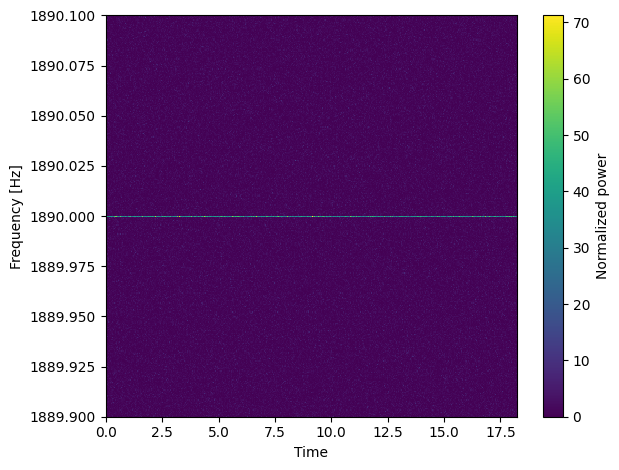

In [ ]:
plt.pcolormesh((times["H1"]-times["H1"][0])/86400, freqs, normalized_power, shading="auto")
plt.xlabel("Time")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Normalized power")
plt.ylim([1889.9,1890.1])
plt.tight_layout()

Q1. Why is the signal monochromatic? Should there be any variations in the frequency over time? Why or why not?

> your response



 Q2: If we wanted to search for a signal at a frequency of 100 Hz, what would be the correpsonding dark-matter mass? What analysis coherence time would we use?

```
# This is formatted as code -- write your response here
```



Q3: If we use the analysis coherence time of 1800 s instead of that computed in Q2, would we gain or lose sensitivity? Explain.



```
# This is formatted as code -- write your response here
```

# Create peakmap from spectrogram

Here, we take the spectrogram computed in PyFstat, and, in each Fast Fourier Transform (that is, at each time in the spectrogram), select local maxima above a chosen threshold. The local maxima criteria reduce the impact of noise lines that may pollute multiple adjacent frequency bins.

We call the resulting thresholded spectrogram a "peakmap", where each surviving time/frequency pixel is called a "peak".

#### Setting threshold on peak selection to be:

In [ ]:
threshold = 3 # need to apply a threshold on equalized power and select maxima above this threshold to run Hough
pm_times,pm_freqs,pm_pows,index = pyhough.pm.make_peakmap_from_spectrogram(times["H1"],freqs,normalized_power,threshold)

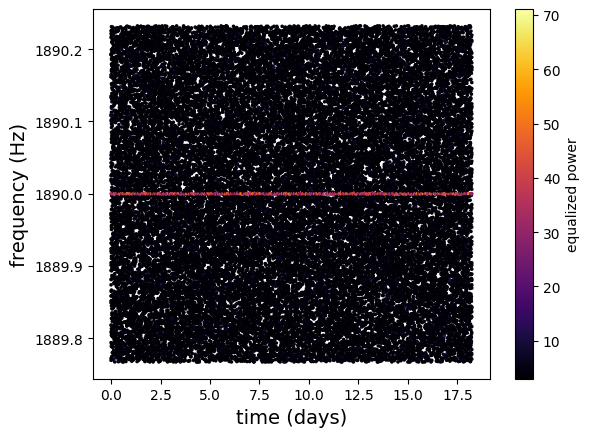

In [ ]:
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,pm_freqs,pm_pows,'.',label='equalized power')
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);
# plt.ylim([99.98,100.02])

# Analysis

Here, we take the peakmap and project it onto the frequency axis. We then calculate a detection statistic, called the critical ratio CR as:

\begin{equation}
CR = \frac{n-\mu}{\sigma}
\end{equation}
where $n$ is the number of peaks that fall into each frequency bin, and $\mu$ and $\sigma$ are the mean and standard deviations of the number counts, respectively


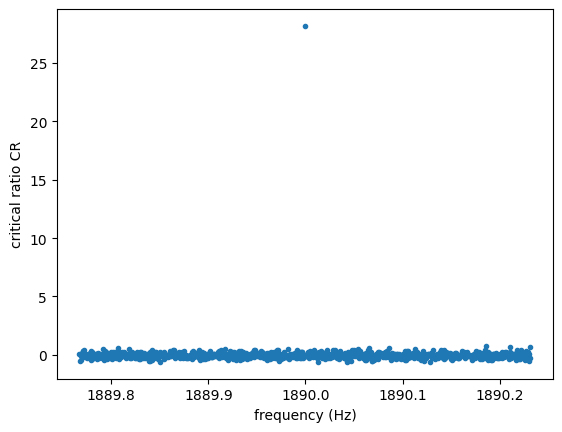

In [ ]:
fbins,counts=pyhough.pm.project_peaks(pm_freqs,pm_freqs)
CRs = (counts - np.mean(counts)) / np.std(counts)

plt.plot(fbins,CRs,'.')
plt.xlabel('frequency (Hz)')
plt.ylabel('critical ratio CR');

Q4: If we didn't apply a threshold or a local maximum criterion, what would the above histogram look like? Can you create a plot of what that would look like using the spectrogram?



```
# This is formatted as code -- write your response here
```



 Q5: based on your answer to Q4, why is it important to threshold the spectrogram?

> your response







To assess the significance of what we find, we have to compare the CR in each frequency bin to the background distributions of the CR. We can do this by creating a split histogram.

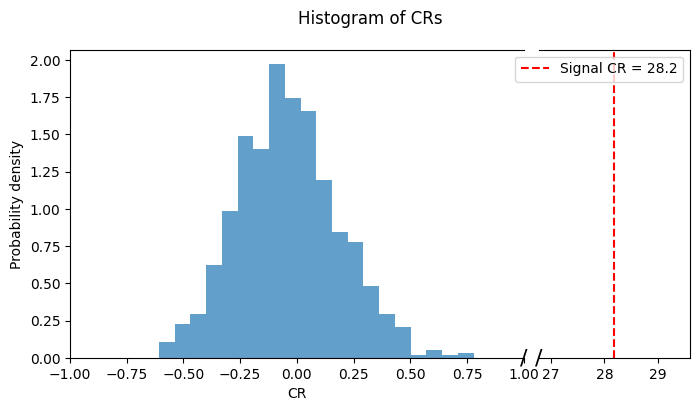

In [ ]:
CRmax = CRs.max()

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, figsize=(8, 4),
    gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05}  # <-- small gap helps aesthetics
)

# Left: histogram
ax1.hist(CRs[CRs < CRmax], bins=20, density=True, alpha=0.7)
ax1.set_xlim(-1, 1)
ax1.set_xlabel("CR")
ax1.set_ylabel("Probability density")

# Right: signal marker
ax2.axvline(CRmax, color="r", linestyle="--", label=f"Signal CR = {CRmax:.1f}")
ax2.set_xlim(CRmax * 0.95, CRmax * 1.05)

# Make it look like a split axis
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.tick_params(left=False)

# Optional: remove top spines
# ax1.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

# --- IMPORTANT: draw the // ABOVE the x-axis in axes coordinates ---
# y=0 is the x-axis baseline in axes coords; put the mark at y=0.03 for visible gap
y_break = 0.
fs = 16

# right edge of left axes
ax1.text(1.0, y_break, "/", transform=ax1.transAxes,
         ha="center", va="center", fontsize=fs, clip_on=False)

# left edge of right axes
ax2.text(0.0, y_break, "/", transform=ax2.transAxes,
         ha="center", va="center", fontsize=fs, clip_on=False)


ax2.legend(loc="upper right");
fig.suptitle("Histogram of CRs");
# fig.tight_layout()
# plt.show()
#

Q6: Does this histogram follow a normal distriubtion? Why or why not? How would the above histogram change if the noise weren't Gaussian? How would you make the histogram follow a normal distribution more closely?




> your response here


Q7: Change the amplitude and frequency of the signal. What happens to the CR? Can you plot how the amplitude changes with CR?



```
# This is formatted as code -- your response here
```

Q8: Change the noise level, while keeping the signal parameters fixed. How does the CR scale with $\sqrt{S_n(f)}$

```
# This is formatted as code -- your response here
```
